# **Projeto Chronos**

- IA para aposta esportiva da caixa loterica loteca. 
- Usando XGboost


***imports***


In [1]:
import pandas as pd
import numpy as np
from textwrap import shorten
from collections import deque
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import os
import glob
import re
import joblib

***Carregar Dados***

In [2]:
# --- ETAPA 1: CARREGAMENTO DOS ARQUIVOS (2006-2012) ---
anos = list(range(2006, 2021))  # 2006 até 2012

# Listas para armazenar todos os DataFrames
df_serie_a_list = []
df_serie_b_list = []
df_times_list = []
df_copa_brasil_list = []
df_libertadores_list = []
df_sudamericana_list = []

for ano in anos:
    
    # Caminhos dos arquivos para o ano atual
    caminho_serie_a = f'dados/brasileiraoA/brasileiraoA{ano}.csv'
    caminho_serie_b = f'dados/brasileiraoB/brasileiraoB{ano}.csv'
    caminho_times = f'dados/times/times{ano}.csv'
    caminho_copa_brasil = f'dados/copadobrasil/copadobrasil{ano}.csv'
    caminho_libertadores = f'dados/libertadores/libertadores{ano}.csv'
    caminho_sudamericana = f'dados/sudamericana/sudamericana{ano}.csv'
    
    try:
        # Carrega cada arquivo e adiciona coluna de ano
        df_a = pd.read_csv(caminho_serie_a)
        df_a['Ano'] = ano
        df_serie_a_list.append(df_a)
        
        df_b = pd.read_csv(caminho_serie_b)
        df_b['Ano'] = ano
        df_serie_b_list.append(df_b)
        
        df_t = pd.read_csv(caminho_times)
        df_t['Ano'] = ano
        df_times_list.append(df_t)
        
        df_cb = pd.read_csv(caminho_copa_brasil)
        df_cb['Ano'] = ano
        df_copa_brasil_list.append(df_cb)
        
        df_lib = pd.read_csv(caminho_libertadores)
        df_lib['Ano'] = ano
        df_libertadores_list.append(df_lib)
        
        df_sud = pd.read_csv(caminho_sudamericana)
        df_sud['Ano'] = ano
        df_sudamericana_list.append(df_sud)
                
    except FileNotFoundError as e:
        print(f"⚠️ Aviso: Arquivo de {ano} não encontrado: {e.filename}")
        continue
    except Exception as e:
        print(f"⚠️ Aviso: Erro ao carregar dados de {ano}: {e}")
        continue

# Verifica se há dados carregados
if not df_serie_a_list:
    print("❌ Erro: Nenhum dado da Série A foi carregado!")
    exit()

# Concatena todos os DataFrames
try:
    df_serie_a = pd.concat(df_serie_a_list, ignore_index=True)
    df_serie_b = pd.concat(df_serie_b_list, ignore_index=True)
    df_times = pd.concat(df_times_list, ignore_index=True)
    df_copa_brasil = pd.concat(df_copa_brasil_list, ignore_index=True)
    df_libertadores = pd.concat(df_libertadores_list, ignore_index=True)
    df_sudamericana = pd.concat(df_sudamericana_list, ignore_index=True)
    
except Exception as e:
    print(f"❌ Erro ao concatenar DataFrames: {e}")
    exit()

# --- ETAPA 2: PROCESSAMENTO DOS DADOS DE COPA ---
# --- FUNÇÃO PARA PROCESSAR JOGOS DE COPA ---
def processar_jogos_copa(df_copa, competicao):
    """Processa os jogos de copa e retorna um dicionário com informações por time"""
    jogos_por_time = {}
    
    # Verifica os nomes das colunas e ajusta conforme necessário
    coluna_mandante = None
    coluna_visitante = None
    coluna_data = None
    coluna_fase = None
    
    # Mapeia possíveis nomes de colunas
    possiveis_colunas = {
        'mandante': ['Time Mandante', 'Mandante', 'Time da Casa', 'Casa'],
        'visitante': ['Time Visitante', 'Visitante', 'Time de Fora', 'Fora'],
        'data': ['Data', 'Date', 'Dia'],
        'fase': ['Fase', 'Phase', 'Stage', 'Rodada']
    }
    
    for col in df_copa.columns:
        col_lower = col.lower()
        if any(x.lower() in col_lower for x in possiveis_colunas['mandante']):
            coluna_mandante = col
        elif any(x.lower() in col_lower for x in possiveis_colunas['visitante']):
            coluna_visitante = col
        elif any(x.lower() in col_lower for x in possiveis_colunas['data']):
            coluna_data = col
        elif any(x.lower() in col_lower for x in possiveis_colunas['fase']):
            coluna_fase = col
    
    if not all([coluna_mandante, coluna_visitante, coluna_data]):
        print(f"❌ Colunas não encontradas em {competicao}")
        return jogos_por_time
    
    for _, jogo in df_copa.iterrows():
        try:
            # Converte a data para formato datetime (tenta diferentes formatos)
            data_str = str(jogo[coluna_data])
            data_jogo = None
            
            # Tenta diferentes formatos de data
            formatos_data = ['%d/%m/%y', '%d/%m/%Y', '%Y-%m-%d', '%m/%d/%Y']
            for formato in formatos_data:
                try:
                    data_jogo = datetime.strptime(data_str, formato)
                    break
                except ValueError:
                    continue
            
            if data_jogo is None:
                continue
            
            # Adiciona informações para o time mandante
            mandante = str(jogo[coluna_mandante]).strip()
            if mandante and mandante != 'nan':
                if mandante not in jogos_por_time:
                    jogos_por_time[mandante] = []
                
                fase = str(jogo[coluna_fase]).strip() if coluna_fase else 'F'
                jogos_por_time[mandante].append({
                    'data': data_jogo,
                    'competicao': competicao,
                    'fase': fase,
                    'adversario': str(jogo[coluna_visitante]).strip(),
                    'local': 'casa'
                })
            
            # Adiciona informações para o time visitante
            visitante = str(jogo[coluna_visitante]).strip()
            if visitante and visitante != 'nan':
                if visitante not in jogos_por_time:
                    jogos_por_time[visitante] = []
                
                fase = str(jogo[coluna_fase]).strip() if coluna_fase else 'F'
                jogos_por_time[visitante].append({
                    'data': data_jogo,
                    'competicao': competicao,
                    'fase': fase,
                    'adversario': str(jogo[coluna_mandante]).strip(),
                    'local': 'fora'
                })
            
        except (ValueError, KeyError) as e:
            continue
    
    return jogos_por_time

# Processa os jogos de copa
jogos_copa_brasil = processar_jogos_copa(df_copa_brasil, 'Copa do Brasil')
jogos_libertadores = processar_jogos_copa(df_libertadores, 'Libertadores')
jogos_sudamericana = processar_jogos_copa(df_sudamericana, 'Sudamericana')
    
# Combina os dois dicionários
todos_jogos_copa = {}
for time in set(list(jogos_copa_brasil.keys()) + list(jogos_libertadores.keys()) + list(jogos_sudamericana.keys())):
    todos_jogos_copa[time] = (jogos_copa_brasil.get(time, []) + 
                             jogos_libertadores.get(time, []) + 
                             jogos_sudamericana.get(time, []))

# Ordena os jogos por data para cada time
for time in todos_jogos_copa:
    if todos_jogos_copa[time]:  # Verifica se há jogos
        todos_jogos_copa[time].sort(key=lambda x: x['data'])


# --- FUNÇÃO AUXILIAR: Ordenação Natural (1, 2, 10 em vez de 1, 10, 2) ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# --- ETAPA 3: CARREGAMENTO DOS ARQUIVOS DE SIMULAÇÃO (2006-2012) ---
anos_simulacao = list(range(2006, 2021))
lista_dfs_simulacao = []

for ano in anos_simulacao:
    caminho_pasta = f'simulacao/{ano}/'
    
    # Verifica se a pasta do ano existe
    if not os.path.exists(caminho_pasta):
        print(f"⚠️ Pasta não encontrada: {caminho_pasta}. Pulando...")
        continue
        
    # Busca arquivos rodada*.csv e ordena corretamente
    arquivos_rodadas = sorted(glob.glob(os.path.join(caminho_pasta, 'rodada*.csv')), key=natural_sort_key)
        
    for arquivo in arquivos_rodadas:
        try:
            df_temp = pd.read_csv(arquivo)
            
            # Adiciona o ano e extrai o número da rodada se não existir
            df_temp['Ano'] = ano
            if 'Rodada' not in df_temp.columns:
                # Extrai o número do nome do arquivo (ex: rodada5.csv -> 5)
                num_rodada = int(re.search(r'rodada(\d+)', arquivo).group(1))
                df_temp['Rodada'] = num_rodada
            
            lista_dfs_simulacao.append(df_temp)
        except Exception as e:
            print(f"⚠️ Erro ao ler {arquivo}: {e}")

# Concatenar todos os DataFrames de simulação
if lista_dfs_simulacao:
    df_simulacao_completo = pd.concat(lista_dfs_simulacao, ignore_index=True)
    
    # Ordenação lógica: primeiro por Ano, depois por Rodada e por fim pelo número do Jogo (1 a 14)
    df_simulacao_completo = df_simulacao_completo.sort_values(by=['Ano', 'Rodada', 'Jogo']).reset_index(drop=True)
    
    # Exibe as primeiras linhas para conferência
else:
    print("❌ Erro: Nenhum arquivo de simulação foi carregado!")


***Features Usadas***

1. Contexto e Identificação

- Rodada: O número da rodada atual (1 a 38).

- Eh_Serie_B: Booleano (0 ou 1) indicando se o jogo pertence à Série B.

- É_Clássico: Booleano indicando se os times são da mesma região geográfica.

2. Tabela e Classificação

- Posicao_Mandante: Posição atual do mandante na tabela.

- Posicao_Visitante: Posição atual do visitante na tabela.

- Diferenca_Posicao: Gap de posições entre os dois times.

- Equilibrio_Posicao: Indica se a distância na tabela é menor ou igual a 3 posições.

- Jogo_de_6_Pontos: Indica se a distância na tabela é menor ou igual a 4 posições.

3. Desempenho de Gols (Histórico da Temporada)

- Media_GM_Casa: Média de gols marcados pelo mandante em casa.

- Media_GS_Casa: Média de gols sofridos pelo mandante em casa.

- Media_GM_Fora: Média de gols marcados pelo visitante fora.

- Media_GS_Fora: Média de gols sofridos pelo visitante fora.

- Saldo_Gols_Casa_Mandante: Saldo acumulado do mandante jogando em casa.

- Saldo_Gols_Fora_Visitante: Saldo acumulado do visitante jogando fora.

- Saldo_Ultimos_5_Casa_Mandante: Soma do saldo de gols nos últimos 5 jogos em casa do mandante.

- Saldo_Ultimos_5_Fora_Visitante: Soma do saldo de gols nos últimos 5 jogos fora do visitante.

4. Força Relativa (Métricas de Domínio)

- Forca_Atk_M: Razão entre gols marcados em casa e a média da liga.

- Forca_Def_V: Razão entre gols sofridos fora e a média da liga.

- Sinal_Dominio: Produto da força de ataque do mandante pela força de defesa do visitante.

- Soma_Forca_Atk_Def: Soma das forças de ataque/defesa.

- Produto_Forca_Atk_Def: Multiplicação das forças.

- Diferenca_Forca_Atk_Def: Diferença absoluta entre ataque M e defesa V.

5. Momentum e Forma Atual

- Sequencia_5_Mandante: String com os últimos 5 resultados (V/E/D).

- Sequencia_5_Visitante: String com os últimos 5 resultados do visitante.

- Momentum_M: Valor numérico ponderado da forma atual do mandante.

- Momentum_V: Valor numérico ponderado da forma atual do visitante.

- Delta_Momentum: Diferença de Momentum entre os dois times.

6. Sensores Psicológicos e Calendário

- Proxima_Copa_Mandante: Identificador de competição/fase de copa próxima.

- Proxima_Copa_Visitante: Identificador para o visitante.

- Desespero_Mandante: Nível de urgência baseado em título ou rebaixamento.

- Desespero_Visitante: Nível de urgência do visitante.

- Delta_Desespero: Diferença entre os níveis de desespero.

- Soberba_Mandante: Risco de relaxamento do mandante (ter copa + adversário fraco).

- Soberba_Visitante: Risco de relaxamento do visitante.

- Delta_Soberba: Diferença de soberba entre os dois.

7. Memória H2H (Head-to-Head desde 2006)

- H2H_Vits_M_Casa: Histórico de vitórias do mandante contra este visitante específico em casa.

- H2H_Derrotas_M_Casa: Histórico de derrotas do mandante contra este visitante em casa.

- H2H_Vits_V_Fora: Histórico de vitórias do visitante contra este mandante fora.

- H2H_Derrotas_V_Fora: Histórico de derrotas do visitante contra este mandante fora.

- H2H_Empates_H2H: Total de empates históricos entre esses dois times nesse mando.

- H2H_Taxa_Vits_M: Percentual de vitórias do mandante no confronto direto.

- H2H_Aproveitamento_M: Métrica de aproveitamento histórico com fator de dúvida (time-decay).

***Features***


In [3]:
# ============================================================================
# FUNÇÕES AUXILIARES
# ============================================================================

def extrair_gols(placar):
    """Extrai gols do placar no formato 'X-Y'."""
    try:
        gols = str(placar).replace('–', '-').split('-')
        return int(gols[0]), int(gols[1])
    except:
        return 0, 0

def calcular_momentum_ia(deque_resultados):
    """Calcula momentum ponderado dos últimos resultados (V/E/D)."""
    if not deque_resultados:
        return 0
    pontos_map = {'V': 3, 'E': 1, 'D': 0}
    vals = [pontos_map.get(res, 0) for res in deque_resultados]
    pesos = range(1, len(vals) + 1)
    return sum(v * p for v, p in zip(vals, pesos)) / sum(pesos)

def calcular_desespero(pos, rd):
    """Calcula nível de desespero baseado na posição e rodada."""
    if rd < 10:
        return 0
    urgencia = 0
    if pos <= 3:
        urgencia = 1.0  # Título
    elif pos <= 8:
        urgencia = 0.7  # Libertadores
    elif pos >= 17:
        urgencia = 1.2  # Rebaixamento
    elif pos >= 14:
        urgencia = 0.5  # Alerta
    return urgencia * (rd / 38)

def get_proxima_copa(time, data_atual):
    """Retorna código da próxima partida de copa (se houver)."""
    if 'todos_jogos_copa' in globals() and time in todos_jogos_copa:
        proximos = [j for j in todos_jogos_copa[time] if j['data'] > data_atual]
        if proximos:
            prox = min(proximos, key=lambda x: x['data'])
            if (prox['data'] - data_atual).days <= 7:
                return f"{prox['competicao'][0]}{prox['fase'][0]}"
    return '-'

def calcular_soberba(tem_copa, pos_time, pos_adv, rodada):
    """Calcula risco de soberba (poupar jogadores)."""
    if tem_copa == 0:
        return 0
    
    gap_tabela = pos_adv - pos_time
    if gap_tabela > 0:
        sinal = (gap_tabela / 20) ** 2
        return sinal * (rodada / 38)
    return 0

def gerar_features_completas(df_jogos, df_times, df_copas=None, stats_h2h=None):
    """
    Gera features para o Projeto Chronos.
    Otimização v3.4: Transformação de H2H absoluto em TAXAS (0 a 1).
    Isso ajuda o XGBoost a entender a probabilidade histórica de cada resultado.
    """
    print("\n--- ⏳ Projeto Chronos: Sincronizando Memória H2H (v3.4 - Modo Taxas) ---")
    
    COLUNA_MANDANTE = 'Time da Casa'
    COLUNA_VISITANTE = 'Time Visitante'
    
    if stats_h2h is None: 
        stats_h2h = {'mando': {}, 'geral': {}}
    elif 'mando' not in stats_h2h:
        stats_h2h = {'mando': {}, 'geral': {}}
    
    # 🛡️ 1. LIMPEZA E PADRONIZAÇÃO
    df_jogos['Data_Datetime'] = pd.to_datetime(df_jogos['Data'], format='%d/%m/%y', dayfirst=True, errors='coerce')
    df_jogos['Rodada'] = pd.to_numeric(df_jogos['Rodada'], errors='coerce')
    df_jogos = df_jogos.dropna(subset=['Data', 'Rodada', 'Placar']).copy()
    df_jogos = df_jogos.sort_values(by=['Rodada', 'Data_Datetime']).reset_index(drop=True)
    
    def parse_gols(p):
        try:
            parts = str(p).replace('–', '-').split('-')
            return int(parts[0]), int(parts[1])
        except: return 0, 0

    df_jogos['Gols_Mandante'] = df_jogos['Placar'].apply(lambda p: parse_gols(p)[0])
    df_jogos['Gols_Visitante'] = df_jogos['Placar'].apply(lambda p: parse_gols(p)[1])
    
    media_gols_liga = df_jogos['Gols_Mandante'].mean() if not df_jogos.empty else 1.2
    mapa_time_regiao = df_times.set_index('time')['região'].to_dict()
    unique_teams = pd.concat([df_jogos[COLUNA_MANDANTE], df_jogos[COLUNA_VISITANTE]]).unique()
    
    # Estados da Temporada
    stats_times = {time: {
        'pontos': 0, 'jogos': 0, 'vitorias': 0, 'sg_casa': 0, 'sg_fora': 0,
        'gols_marcados_casa': 0, 'gols_sofridos_casa': 0, 'jogos_casa': 0,
        'gols_marcados_fora': 0, 'gols_sofridos_fora': 0, 'jogos_fora': 0,
        'ultimos_5_saldos_casa': deque(maxlen=5), 'ultimos_5_saldos_fora': deque(maxlen=5),
        'ultimos_5_resultados': deque(maxlen=5)
    } for time in unique_teams}
    
    # Lista de colunas (Agora focada em TAXAS de 0 a 1)
    chaves_f = [
        'Eh_Serie_B', 'Posicao_Mandante', 'Posicao_Visitante', 'Media_GM_Casa', 
        'Media_GS_Casa', 'Media_GM_Fora', 'Media_GS_Fora', 'Saldo_Gols_Casa_Mandante', 
        'Saldo_Gols_Fora_Visitante', 'Saldo_Ultimos_5_Casa_Mandante', 
        'Saldo_Ultimos_5_Fora_Visitante', 'Sequencia_5_Mandante', 'Sequencia_5_Visitante',
        'Momentum_M', 'Momentum_V', 'Proxima_Copa_Mandante', 'Proxima_Copa_Visitante',
        'Forca_Atk_M', 'Forca_Def_V', 'Sinal_Dominio', 'Desespero_Mandante', 
        'Desespero_Visitante', 'Delta_Desespero', 'Soberba_Mandante', 
        'Soberba_Visitante', 'Delta_Soberba', 
        # Colunas H2H transformadas em Taxas
        'H2H_Vits_M_Casa', 'H2H_Derrotas_M_Casa', 'H2H_Vits_V_Fora', 
        'H2H_Derrotas_V_Fora', 'H2H_Empates_H2H', 'H2H_Taxa_Vits_M', 'H2H_Aproveitamento_M'
    ]
    listas_features = {k: [] for k in chaves_f}

    # ============================================================================
    # PROCESSAMENTO RODADA A RODADA
    # ============================================================================
    for rodada in range(1, 39):
        df_class = pd.DataFrame.from_dict(stats_times, orient='index')
        df_class['sg_total'] = df_class['sg_casa'] + df_class['sg_fora']
        df_class = df_class.sort_values(by=['pontos', 'vitorias', 'sg_total'], ascending=False)
        df_class['posicao'] = range(1, len(df_class) + 1)
        mapa_posicao = df_class['posicao'].to_dict()
        
        jogos_rd = df_jogos[df_jogos['Rodada'] == rodada]
        
        for _, jogo in jogos_rd.iterrows():
            m = str(jogo[COLUNA_MANDANTE]).strip()
            v = str(jogo[COLUNA_VISITANTE]).strip()
            
            # 🧠 1. LEITURA H2H E CONVERSÃO PARA TAXAS (O que aconteceu ANTES deste jogo)
            key_mando = (m, v)
            key_geral = tuple(sorted([m, v]))
            
            h_mando = stats_h2h['mando'].get(key_mando, {'v_m': 0, 'v_v': 0, 'e': 0})
            h_geral = stats_h2h['geral'].get(key_geral, {'v_t1': 0, 'v_t2': 0, 'e': 0})
            
            total_mando = h_mando['v_m'] + h_mando['v_v'] + h_mando['e']
            
            # Conversão para Taxas (0 a 1) como solicitado:
            if total_mando > 0:
                listas_features['H2H_Vits_M_Casa'].append(h_mando['v_m'] / total_mando)
                listas_features['H2H_Derrotas_M_Casa'].append(h_mando['v_v'] / total_mando)
                listas_features['H2H_Vits_V_Fora'].append(h_mando['v_v'] / total_mando)
                listas_features['H2H_Derrotas_V_Fora'].append(h_mando['v_m'] / total_mando)
                listas_features['H2H_Empates_H2H'].append(h_mando['e'] / total_mando)
                listas_features['H2H_Taxa_Vits_M'].append(h_mando['v_m'] / total_mando)
            else:
                # Prior de incerteza (distribuição uniforme ou 0.5)
                for col in ['H2H_Vits_M_Casa', 'H2H_Derrotas_M_Casa', 'H2H_Vits_V_Fora', 
                            'H2H_Derrotas_V_Fora', 'H2H_Empates_H2H']:
                    listas_features[col].append(0.0) 
                listas_features['H2H_Taxa_Vits_M'].append(0.5)
            
            # Aproveitamento M usando o histórico GERAL transformado em taxa
            t1, t2 = key_geral
            v_m_g = h_geral['v_t1'] if t1 == m else h_geral['v_t2']
            total_g = h_geral['v_t1'] + h_geral['v_t2'] + h_geral['e']
            listas_features['H2H_Aproveitamento_M'].append(v_m_g / total_g if total_g > 0 else 0.5)

            # 🚀 2. OUTROS SENSORES
            st_m, st_v = stats_times[m], stats_times[v]
            pos_m, pos_v = mapa_posicao.get(m, 21), mapa_posicao.get(v, 21)
            
            listas_features['Eh_Serie_B'].append(jogo.get('Eh_Serie_B', 0))
            listas_features['Posicao_Mandante'].append(pos_m)
            listas_features['Posicao_Visitante'].append(pos_v)
            listas_features['Momentum_M'].append(calcular_momentum_ia(st_m['ultimos_5_resultados']))
            listas_features['Momentum_V'].append(calcular_momentum_ia(st_v['ultimos_5_resultados']))
            
            d_m, d_v = calcular_desespero(pos_m, rodada), calcular_desespero(pos_v, rodada)
            listas_features['Desespero_Mandante'].append(d_m)
            listas_features['Desespero_Visitante'].append(d_v)
            listas_features['Delta_Desespero'].append(d_m - d_v)
            
            prox_m = get_proxima_copa(m, jogo['Data_Datetime'])
            prox_v = get_proxima_copa(v, jogo['Data_Datetime'])
            listas_features['Proxima_Copa_Mandante'].append(prox_m)
            listas_features['Proxima_Copa_Visitante'].append(prox_v)
            
            sob_m = calcular_soberba(1 if prox_m != '-' else 0, pos_m, pos_v, rodada)
            sob_v = calcular_soberba(1 if prox_v != '-' else 0, pos_v, pos_m, rodada)
            listas_features['Soberba_Mandante'].append(sob_m)
            listas_features['Soberba_Visitante'].append(sob_v)
            listas_features['Delta_Soberba'].append(sob_m - sob_v)

            mgm_c = st_m['gols_marcados_casa'] / st_m['jogos_casa'] if st_m['jogos_casa'] > 0 else 0
            mgs_f = st_v['gols_sofridos_fora'] / st_v['jogos_fora'] if st_v['jogos_fora'] > 0 else 0
            listas_features['Media_GM_Casa'].append(mgm_c)
            listas_features['Media_GS_Casa'].append(st_m['gols_sofridos_casa'] / st_m['jogos_casa'] if st_m['jogos_casa'] > 0 else 0)
            listas_features['Media_GM_Fora'].append(st_v['gols_marcados_fora'] / st_v['jogos_fora'] if st_v['jogos_fora'] > 0 else 0)
            listas_features['Media_GS_Fora'].append(mgs_f)
            listas_features['Saldo_Gols_Casa_Mandante'].append(st_m['sg_casa'])
            listas_features['Saldo_Gols_Fora_Visitante'].append(st_v['sg_fora'])
            listas_features['Saldo_Ultimos_5_Casa_Mandante'].append(sum(st_m['ultimos_5_saldos_casa']))
            listas_features['Saldo_Ultimos_5_Fora_Visitante'].append(sum(st_v['ultimos_5_saldos_fora']))
            listas_features['Sequencia_5_Mandante'].append(''.join(st_m['ultimos_5_resultados']) or '-')
            listas_features['Sequencia_5_Visitante'].append(''.join(st_v['ultimos_5_resultados']) or '-')
            listas_features['Forca_Atk_M'].append(mgm_c / media_gols_liga)
            listas_features['Forca_Def_V'].append(mgs_f / media_gols_liga)
            listas_features['Sinal_Dominio'].append((mgm_c / media_gols_liga) * (mgs_f / media_gols_liga))

            # 🔄 3. ATUALIZAÇÃO DA MEMÓRIA (PÓS-JOGO)
            g_m, g_v = jogo['Gols_Mandante'], jogo['Gols_Visitante']
            
            if key_mando not in stats_h2h['mando']: stats_h2h['mando'][key_mando] = {'v_m': 0, 'v_v': 0, 'e': 0}
            if g_m > g_v: stats_h2h['mando'][key_mando]['v_m'] += 1
            elif g_v > g_m: stats_h2h['mando'][key_mando]['v_v'] += 1
            else: stats_h2h['mando'][key_mando]['e'] += 1
            
            if key_geral not in stats_h2h['geral']: stats_h2h['geral'][key_geral] = {'v_t1': 0, 'v_t2': 0, 'e': 0}
            if g_m > g_v:
                stats_h2h['geral'][key_geral]['v_t1' if t1 == m else 'v_t2'] += 1
            elif g_v > g_m:
                stats_h2h['geral'][key_geral]['v_t2' if t1 == m else 'v_t1'] += 1
            else:
                stats_h2h['geral'][key_geral]['e'] += 1
            
            res_m, res_v = ('V', 'D') if g_m > g_v else (('D', 'V') if g_v > g_m else ('E', 'E'))
            st_m['ultimos_5_resultados'].append(res_m); st_v['ultimos_5_resultados'].append(res_v)
            st_m['jogos_casa'] += 1; st_m['gols_marcados_casa'] += g_m; st_m['gols_sofridos_casa'] += g_v; st_m['sg_casa'] += (g_m - g_v)
            st_v['jogos_fora'] += 1; st_v['gols_marcados_fora'] += g_v; st_v['gols_sofridos_fora'] += g_m; st_v['sg_fora'] += (g_v - g_m)
            if g_m > g_v: st_m['pontos'] += 3; st_m['vitorias'] += 1
            elif g_v > g_m: st_v['pontos'] += 3; st_v['vitorias'] += 1
            else: st_m['pontos'] += 1; st_v['pontos'] += 1

    # 🛡️ 4. FINALIZAÇÃO
    for nome, lista in listas_features.items():
        df_jogos[nome] = lista
    
    df_jogos['Diferenca_Posicao'] = df_jogos['Posicao_Mandante'] - df_jogos['Posicao_Visitante']
    df_jogos['Delta_Momentum'] = df_jogos['Momentum_M'] - df_jogos['Momentum_V']
    df_jogos['Soma_Forca_Atk_Def'] = df_jogos['Forca_Atk_M'] + df_jogos['Forca_Def_V']
    df_jogos['Produto_Forca_Atk_Def'] = df_jogos['Forca_Atk_M'] * df_jogos['Forca_Def_V']
    df_jogos['Diferenca_Forca_Atk_Def'] = abs(df_jogos['Forca_Atk_M'] - df_jogos['Forca_Def_V'])
    df_jogos['Media_Forca_Atk_Def'] = df_jogos['Soma_Forca_Atk_Def'] / 2
    df_jogos['É_Clássico'] = (df_jogos[COLUNA_MANDANTE].map(mapa_time_regiao) == 
                               df_jogos[COLUNA_VISITANTE].map(mapa_time_regiao)).astype(int)
    
    print(f"✅ Sincronização v3.4 Concluída. H2H em escala de frequência (0 a 1).")
    return df_jogos

***Memoria do H2H***

In [4]:
# 1. CRIAMOS A MEMÓRIA VAZIA (SÓ UMA VEZ!)
memoria_h2h = {} 
df_lista_treino = []

# 2. PERCORRENDO OS ANOS (REVEZAMENTO DE DADOS)
for ano in range(2006, 2021):
    
    # Carregue seus dados aqui (exemplo de nomes de arquivos)
    df_a = pd.read_csv(f'dados/brasileiraoA/brasileiraoA{ano}.csv')
    df_b = pd.read_csv(f'dados/brasileiraoB/brasileiraoB{ano}.csv')
    df_t = pd.read_csv(f'dados/times/times{ano}.csv')
    
    # Marcando as séries
    df_a['Eh_Serie_B'] = 0
    df_b['Eh_Serie_B'] = 1
    
    # 🧠 O PULO DO GATO: Passamos a 'memoria_h2h' para a função.
    # Ela vai ler o que já tem lá (anos anteriores) e SALVAR o que acontecer agora.
    df_a_enriq = gerar_features_completas(df_a, df_t, stats_h2h=memoria_h2h)
    df_b_enriq = gerar_features_completas(df_b, df_t, stats_h2h=memoria_h2h)
    
    df_lista_treino.append(df_a_enriq)
    df_lista_treino.append(df_b_enriq)

# 3. UNIFICANDO TUDO EM UM SUPER BANCO DE DADOS
df_total_treino = pd.concat(df_lista_treino, ignore_index=True)

# --- PROVA REAL ---
print("\n📊 Verificação de sanidade do H2H:")
print(f"Total de vitórias acumuladas no H2H: {df_total_treino['H2H_Vits_M_Casa'].sum()}")
print(f"Total de derrotas acumuladas no H2H: {df_total_treino['H2H_Derrotas_M_Casa'].sum()}")
print(f"Total de vitórias acumuladas no H2H fora: {df_total_treino['H2H_Vits_V_Fora'].sum()}")
print(f"Total de derrotas acumuladas no H2H fora: {df_total_treino['H2H_Derrotas_V_Fora'].sum()}")
print(f"Total de empates acumulados no H2H: {df_total_treino['H2H_Empates_H2H'].sum()}")
print(f"Total de jogos com histórico H2H: {(df_total_treino['H2H_Vits_M_Casa'] + df_total_treino['H2H_Derrotas_M_Casa'] + df_total_treino['H2H_Empates_H2H']).sum()}")
print(f"Total de jogos no dataset: {len(df_total_treino)}")


--- ⏳ Projeto Chronos: Sincronizando Memória H2H (v3.4 - Modo Taxas) ---
✅ Sincronização v3.4 Concluída. H2H em escala de frequência (0 a 1).

--- ⏳ Projeto Chronos: Sincronizando Memória H2H (v3.4 - Modo Taxas) ---
✅ Sincronização v3.4 Concluída. H2H em escala de frequência (0 a 1).

--- ⏳ Projeto Chronos: Sincronizando Memória H2H (v3.4 - Modo Taxas) ---
✅ Sincronização v3.4 Concluída. H2H em escala de frequência (0 a 1).

--- ⏳ Projeto Chronos: Sincronizando Memória H2H (v3.4 - Modo Taxas) ---
✅ Sincronização v3.4 Concluída. H2H em escala de frequência (0 a 1).

--- ⏳ Projeto Chronos: Sincronizando Memória H2H (v3.4 - Modo Taxas) ---
✅ Sincronização v3.4 Concluída. H2H em escala de frequência (0 a 1).

--- ⏳ Projeto Chronos: Sincronizando Memória H2H (v3.4 - Modo Taxas) ---
✅ Sincronização v3.4 Concluída. H2H em escala de frequência (0 a 1).

--- ⏳ Projeto Chronos: Sincronizando Memória H2H (v3.4 - Modo Taxas) ---
✅ Sincronização v3.4 Concluída. H2H em escala de frequência (0 a 1).

***preparar o treino***

In [5]:
def preparar_para_xgboost(df):
    df_ml = df.copy()
    
    # 1. Variável Alvo (Target) - Tratando possíveis nomes diferentes de colunas
    def definir_alvo(row):
        # Tenta Gols_Mandante ou Gols_M (flexibilidade para seus CSVs)
        gm = row.get('Gols_Mandante', row.get('Gols_M', 0))
        gv = row.get('Gols_Visitante', row.get('Gols_V', 0))
        if gm > gv: return 1   # Vitória Casa
        if gv > gm: return 2   # Vitória Fora
        return 0               # Empate
    
    df_ml['Target'] = df_ml.apply(definir_alvo, axis=1)
    
    # 2. Conversões de Sensores Básicos
    def converter_sequencia(seq):
        if seq == '-' or pd.isna(seq): return 0
        mapa_pts = {'V': 3, 'E': 1, 'D': 0}
        return sum(mapa_pts.get(resultado, 0) for resultado in str(seq))

    # Criando sensores de Ponto e Copa
    if 'Sequencia_5_Mandante' in df_ml.columns:
        df_ml['Pts_Ultimos_5_M'] = df_ml['Sequencia_5_Mandante'].apply(converter_sequencia)
        df_ml['Pts_Ultimos_5_V'] = df_ml['Sequencia_5_Visitante'].apply(converter_sequencia)
    
    if 'Proxima_Copa_Mandante' in df_ml.columns:
        df_ml['Tem_Copa_M'] = (df_ml['Proxima_Copa_Mandante'] != '-').astype(int)
        df_ml['Tem_Copa_V'] = (df_ml['Proxima_Copa_Visitante'] != '-').astype(int)

    # 3. LISTA FINAL DE RECURSOS (33 Sensores)
    colunas_finais = [
        'Rodada', 'Posicao_Mandante', 'Posicao_Visitante', 'Diferenca_Posicao',
        'Media_GM_Casa', 'Media_GS_Casa', 'Media_GM_Fora', 'Media_GS_Fora',
        'Saldo_Gols_Casa_Mandante', 'Saldo_Gols_Fora_Visitante',
        'Saldo_Ultimos_5_Casa_Mandante', 'Saldo_Ultimos_5_Fora_Visitante',
        'Pts_Ultimos_5_M', 'Pts_Ultimos_5_V',
        'Tem_Copa_M', 'Tem_Copa_V', 'É_Clássico', 'Jogo_de_6_Pontos',
        'Forca_Atk_M', 'Forca_Def_V', 'Sinal_Dominio', 
        'Momentum_M', 'Momentum_V', 'Delta_Momentum',
        'Soma_Forca_Atk_Def', 'Produto_Forca_Atk_Def', 'Diferenca_Forca_Atk_Def',
        'Desespero_Mandante', 'Desespero_Visitante', 'Delta_Desespero',
        'Soberba_Mandante', 'Soberba_Visitante', 'Delta_Soberba',
        'H2H_Vits_M_Casa', 'H2H_Derrotas_M_Casa', 
        'H2H_Vits_V_Fora', 'H2H_Derrotas_V_Fora', 'H2H_Empates_H2H', 'H2H_Taxa_Vits_M','H2H_Aproveitamento_M',
    ]

    # --- 🛡️ PROTEÇÃO CONTRA KEYERROR ---
    # Se alguma coluna da lista não existir no DF, cria ela com zero
    for col in colunas_finais:
        if col not in df_ml.columns:
            df_ml[col] = 0

    # 4. Limpeza e Matriz Final
    X = df_ml[colunas_finais].fillna(0)
    y = df_ml['Target']

    return X, y

# --- EXECUÇÃO DO FLUXO ---
# 1. Carrega os dados
df_bruto_a = pd.read_csv(caminho_serie_a)
df_bruto_b = pd.read_csv(caminho_serie_b)

# 2. Gera as features (Sinal de 74.8% + Desespero)
df_enriquecido_a = gerar_features_completas(df_bruto_a, df_times)
df_enriquecido_b = gerar_features_completas(df_bruto_b, df_times)

# 3. Une as bases
df_total_enriquecido = pd.concat([df_enriquecido_a, df_enriquecido_b], ignore_index=True)
print(f"✅ Base unificada com {len(df_total_enriquecido)} jogos.")

# 4. Prepara para o Treino
X, y = preparar_para_xgboost(df_total_enriquecido)


--- ⏳ Projeto Chronos: Sincronizando Memória H2H (v3.4 - Modo Taxas) ---
✅ Sincronização v3.4 Concluída. H2H em escala de frequência (0 a 1).

--- ⏳ Projeto Chronos: Sincronizando Memória H2H (v3.4 - Modo Taxas) ---
✅ Sincronização v3.4 Concluída. H2H em escala de frequência (0 a 1).
✅ Base unificada com 757 jogos.


***TREINO***

📊 Acurácia no treino: 95.24%


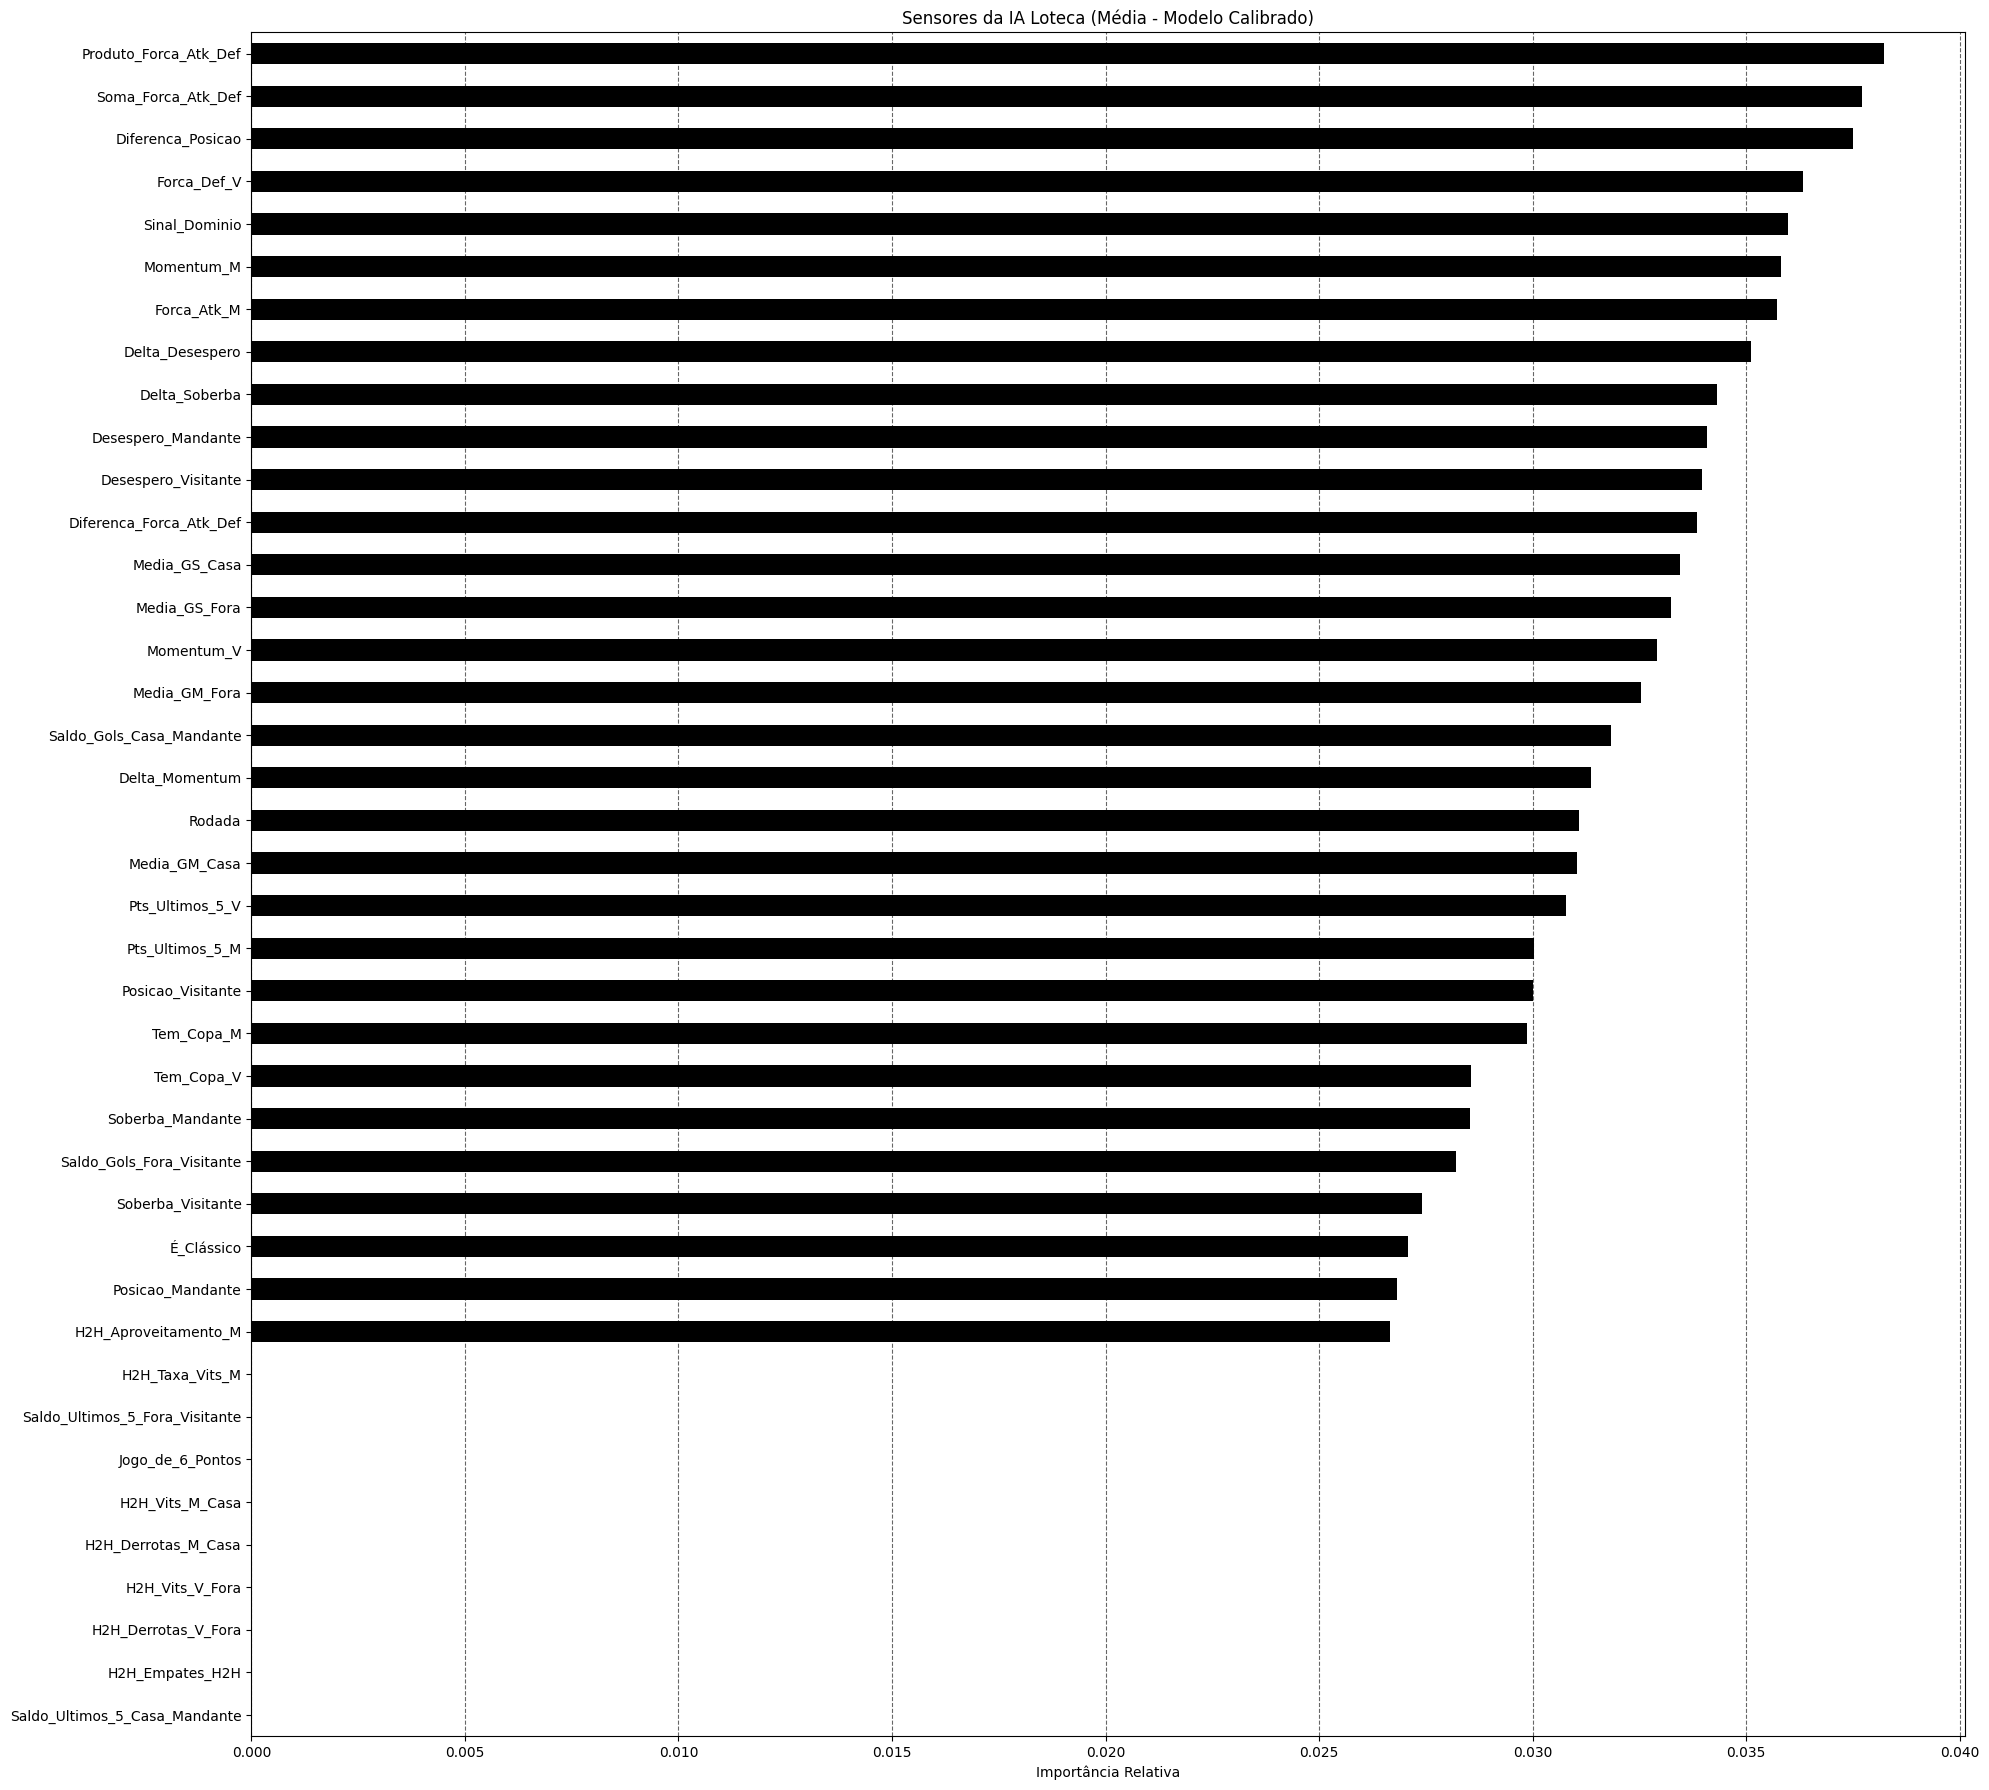

In [6]:
# --- Treino Otimizado para Estabilidade (Projeto Loteca) ---
modelo_loteca = xgb.XGBClassifier(
    max_depth=4,           # Mais profundidade para pegar padrões complexos
    learning_rate=0.03, 
    n_estimators=300, 
    subsample=0.9, 
    colsample_bytree=0.9
)
#modelo_loteca = CalibratedClassifierCV(modelo_loteca, method='sigmoid', cv=5)
modelo_loteca.fit(X, y)

# Fazendo a previsão nos mesmos dados de treino
pred_treino = modelo_loteca.predict(X)
acuracia = accuracy_score(y, pred_treino)

print(f"📊 Acurácia no treino: {acuracia:.2%}")
# 1. Extrair e tirar a média das importâncias usando o novo atributo 'estimator'


# 2. Criar a Series com os nomes das colunas
importancias = pd.Series(modelo_loteca.feature_importances_, index=X.columns)

# 3. Plotar o gráfico com os 45 sensores mais influentes
plt.figure(figsize=(20, 18))
importancias.nlargest(41).sort_values(ascending=True).plot(kind='barh', color='black')
plt.title("Sensores da IA Loteca (Média - Modelo Calibrado)")
plt.xlabel("Importância Relativa")
plt.grid(axis='x', linestyle='--', alpha=0.6, color='black')
plt.tight_layout()
plt.show()

***Função para Fazer o teste da IA***

In [7]:
resultado_simulacao = []

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def converter_sequencia(seq):
    if seq == '-' or pd.isna(seq): return 0
    mapa_pts = {'V': 3, 'E': 1, 'D': 0}
    return sum(mapa_pts.get(resultado, 0) for resultado in seq)

def executar_simulacao(diretorio, df_gabarito, modelo_ia, threshold):
    arquivos = sorted(glob.glob(os.path.join(diretorio, 'rodada*.csv')), key=natural_sort_key)
    mapa_res = {1: "CASA  ", 0: "EMPATE", 2: "FORA  "}

    for caminho in arquivos:
        df_concurso = pd.read_csv(caminho)
        nome_arquivo = os.path.basename(caminho)
        jogos_analise = []

        # 1. COLETA DE DADOS (Sem ordenar ainda)
        for i, jogo in df_concurso.iterrows():
            m, v = jogo['Time da Casa'], jogo['Time Visitante']
            jr = df_gabarito[(df_gabarito['Time da Casa'] == m) & (df_gabarito['Time Visitante'] == v)]
            if jr.empty: continue
            
            real_num = 1 if jr['Gols_Mandante'].values[0] > jr['Gols_Visitante'].values[0] else (2 if jr['Gols_Visitante'].values[0] > jr['Gols_Mandante'].values[0] else 0)
            stats_m = df_gabarito[(df_gabarito['Time da Casa'] == m) | (df_gabarito['Time Visitante'] == m)].tail(1)
            stats_v = df_gabarito[(df_gabarito['Time da Casa'] == v) | (df_gabarito['Time Visitante'] == v)].tail(1)

            # (O input_ia deve conter todas as 24 features conforme o teu treino anterior)
            input_ia = pd.DataFrame([{
                'Rodada': jogo['Rodada'], 'Posicao_Mandante': stats_m['Posicao_Mandante'].values[0],
                'Posicao_Visitante': stats_v['Posicao_Visitante'].values[0],
                'Diferenca_Posicao': stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0],
                'Media_GM_Casa': stats_m['Media_GM_Casa'].values[0], 'Media_GS_Casa': stats_m['Media_GS_Casa'].values[0],
                'Media_GM_Fora': stats_v['Media_GM_Fora'].values[0], 'Media_GS_Fora': stats_v['Media_GS_Fora'].values[0],
                'Saldo_Gols_Casa_Mandante': stats_m['Saldo_Gols_Casa_Mandante'].values[0],
                'Saldo_Gols_Fora_Visitante': stats_v['Saldo_Gols_Fora_Visitante'].values[0],
                'Saldo_Ultimos_5_Casa_Mandante': stats_m['Saldo_Ultimos_5_Casa_Mandante'].values[0],
                'Saldo_Ultimos_5_Fora_Visitante': stats_v['Saldo_Ultimos_5_Fora_Visitante'].values[0],
                'Pts_Ultimos_5_M': converter_sequencia(stats_m['Sequencia_5_Mandante'].values[0]),
                'Pts_Ultimos_5_V': converter_sequencia(stats_v['Sequencia_5_Visitante'].values[0]),
                'Tem_Copa_M': 1 if stats_m['Proxima_Copa_Mandante'].values[0] != '-' else 0,
                'Tem_Copa_V': 1 if stats_v['Proxima_Copa_Visitante'].values[0] != '-' else 0,
                'É_Clássico': jogo['É_Clássico'] if 'É_Clássico' in jogo else 0,
                'Jogo_de_6_Pontos': 1 if abs(stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0]) <= 4 else 0,
                'Forca_Atk_M': stats_m['Forca_Atk_M'].values[0], 'Forca_Def_V': stats_v['Forca_Def_V'].values[0],
                'Sinal_Dominio': stats_m['Sinal_Dominio'].values[0], 'Momentum_M': stats_m['Momentum_M'].values[0],
                'Momentum_V': stats_v['Momentum_V'].values[0], 'Delta_Momentum': stats_m['Momentum_M'].values[0] - stats_v['Momentum_V'].values[0],
                'Soma_Forca_Atk_Def': stats_m['Soma_Forca_Atk_Def'].values[0],
                'Produto_Forca_Atk_Def': stats_m['Produto_Forca_Atk_Def'].values[0],
                'Diferenca_Forca_Atk_Def': abs(stats_m['Forca_Atk_M'].values[0] - stats_v['Forca_Def_V'].values[0]),
                'Desespero_Mandante': stats_m['Desespero_Mandante'].values[0],
                'Desespero_Visitante': stats_v['Desespero_Visitante'].values[0],
                'Delta_Desespero': stats_m['Delta_Desespero'].values[0],
                'Soberba_Mandante': stats_m['Soberba_Mandante'].values[0],
                'Soberba_Visitante': stats_v['Soberba_Visitante'].values[0],
                'Delta_Soberba': stats_m['Delta_Soberba'].values[0],
                'H2H_Vits_M_Casa': stats_m['H2H_Vits_M_Casa'].values[0],
                'H2H_Derrotas_M_Casa': stats_m['H2H_Derrotas_M_Casa'].values[0],
                'H2H_Vits_V_Fora': stats_v['H2H_Vits_V_Fora'].values[0],
                'H2H_Derrotas_V_Fora': stats_v['H2H_Derrotas_V_Fora'].values[0],
                'H2H_Empates_H2H': stats_m['H2H_Empates_H2H'].values[0],
                'H2H_Taxa_Vits_M': stats_m['H2H_Taxa_Vits_M'].values[0],
                'H2H_Aproveitamento_M': stats_m['H2H_Aproveitamento_M'].values[0]
            }])

            # --- 🎲 CÁLCULO DAS PROBABILIDADES ---
            probs = modelo_ia.predict_proba(input_ia)[0]
            ordem = np.argsort(probs)[::-1] # Índices do maior para o menor
            
            p_casa = probs[1]
            p_empate = probs[0]
            p_fora = probs[2]

            # ====================================================================
            # 🛡️ FILTRO RESTAURADO: REGRA DO EMPATE (25%)
            # ====================================================================
            # Se a chance de empate for >= 25% OU a diferença Casa/Fora for < threshold
            if p_empate >= 0.3 or abs(p_casa - p_fora) < p_empate:
                p_primario = 0  # Prioridade 1: Empate
            else:
                p_primario = np.argmax(probs) # Caso contrário, vai na maior prob
            
            # Define o palpite secundário (o melhor entre os que sobraram)
            p_secundario = ordem[1] if ordem[0] == p_primario else ordem[0]
            # ====================================================================

            jogos_analise.append({
                'id_original': i, 
                'confronto': f"{m[:12]} x {v[:12]}", 'real': real_num, 
                'p1': p_primario, 'p2': p_secundario,
                'gap': abs(p_casa - p_fora), # Gap entre times para decidir Duplos/Triplos
                'probs': probs,
                'p_casa': p_casa, 'p_empate': p_empate, 'p_fora': p_fora,
                'tipo': 'S' 
            })

        # 2. ALOCAÇÃO INTELIGENTE DE RECURSOS
        # Ordenamos temporariamente para decidir onde gastar
        jogos_analise.sort(key=lambda x: x['gap'])
        
        for idx, j in enumerate(jogos_analise):
            if idx == 0: j['tipo'] = 'T' # O mais incerto de todos leva o TRIPLO
            elif idx < 3: j['tipo'] = 'D' # Os próximos 6 levam DUPLO

        # 3. VOLTA À ORDEM ORIGINAL E IMPRIME
        jogos_analise.sort(key=lambda x: x['id_original'])

        print(f"\n# {nome_arquivo.upper()} - BILHETE FINAL #")
        print(f"{'J':<2} | {'CONFRONTO':<32} | {'TIPO':<4} | {'CASA%':<6} | {'EMP%':<6} | {'FORA%':<6} | {'PALPITE':<18} | {'REAL':<8} | {'STATUS'}")        
        print("-" * 130)

        acertos = 0
        for idx, j in enumerate(jogos_analise):
            p_max = np.max(j['probs'])
            
            # Validação
            acertou = (j['tipo'] == "T") or (j['tipo'] == "D" and (j['p1'] == j['real'] or j['p2'] == j['real'])) or (j['tipo'] == "S" and j['p1'] == j['real'])
            if acertou: 
                acertos += 1
                resultado_simulacao.append(acertos)

            palpite_str = "TRIPLO" if j['tipo'] == "T" else (f"{mapa_res[j['p1']]} / {mapa_res[j['p2']]}" if j['tipo'] == "D" else mapa_res[j['p1']])
            status = "✅" if acertou else "❌"
            print(f"{idx+1:<2} | {j['confronto']:<32} | {j['tipo']:<4} | {j['p_casa']:>6.1%} | {j['p_empate']:>6.1%} | {j['p_fora']:>6.1%} | {palpite_str:<18} |{mapa_res[j['real']]:<8}| {status}")
            #print(f"{idx+1:<2} | {j['confronto']:<28} | {j['tipo']:<4} | {p_max:.1%} | {palpite_str:<18} | {mapa_res[j['real']]:<8} | {status}")

        print(f"\n📊 TOTAL: {acertos}/14")
        print(f"📈 ACURÁCIA: {acertos/14:.1%}")

***Simulação detalhada***

In [8]:
# 1. LIGAS NACIONAIS
df_13_a = pd.read_csv('dados/brasileiraoA/brasileiraoA2022.csv')
df_13_b = pd.read_csv('dados/brasileiraoB/brasileiraoB2022.csv')
df_13_a['Eh_Serie_B'] = 0
df_13_b['Eh_Serie_B'] = 1

# 2. METADADOS DOS TIMES (Regiões)
df_times_13 = pd.read_csv('dados/times/times2022.csv')

# 3. COMPETIÇÕES DE MATA-MATA (As Copas)
try:
    df_cb_13 = pd.read_csv('dados/copadobrasil/copadobrasil2022.csv')
    df_lib_13    = pd.read_csv('dados/libertadores/libertadores2022.csv')
    df_sud_13 = pd.read_csv('dados/sudamericana/sudamericana2022.csv')
    
    # Unifica todas as copas em um "Calendário Master" para o motor de features
    df_copas_13 = pd.concat([df_cb_13, df_lib_13, df_sud_13], ignore_index=True)
except FileNotFoundError as e:
    print(f"⚠️ Aviso: Algum arquivo de copa não foi encontrado: {e.filename}")
    # Cria um DF vazio com as colunas necessárias para não quebrar a função
    df_copas_13 = pd.DataFrame(columns=['Data', 'Time da Casa', 'Time Visitante'])

# 4. GERAÇÃO DO GABARITO ENRIQUECIDO
# Nota: Certifique-se de que sua função 'gerar_features_completas' aceite o argumento das copas

df_gabarito_13 = pd.concat([
    gerar_features_completas(df_13_a, df_times_13, df_copas_13,memoria_h2h),
    gerar_features_completas(df_13_b, df_times_13, df_copas_13,memoria_h2h)
], ignore_index=True)

# 5. EXECUÇÃO DA SIMULAÇÃO
executar_simulacao(
    diretorio='simulacao/2022', 
    df_gabarito=df_gabarito_13, 
    modelo_ia=modelo_loteca, 
    threshold=0.00
)


--- ⏳ Projeto Chronos: Sincronizando Memória H2H (v3.4 - Modo Taxas) ---
✅ Sincronização v3.4 Concluída. H2H em escala de frequência (0 a 1).

--- ⏳ Projeto Chronos: Sincronizando Memória H2H (v3.4 - Modo Taxas) ---
✅ Sincronização v3.4 Concluída. H2H em escala de frequência (0 a 1).

# RODADA1.CSV - BILHETE FINAL #
J  | CONFRONTO                        | TIPO | CASA%  | EMP%   | FORA%  | PALPITE            | REAL     | STATUS
----------------------------------------------------------------------------------------------------------------------------------
1  | Brusque x Guarani                | S    |  60.4% |  19.4% |  20.2% | CASA               |CASA    | ✅
2  | Bahia x Cruzeiro                 | S    |  43.0% |  49.6% |   7.4% | EMPATE             |CASA    | ❌
3  | Fluminense x Santos              | S    |  60.7% |  15.4% |  23.9% | CASA               |EMPATE  | ❌
4  | Atlético-GO x Flamengo           | S    |  46.6% |  41.1% |  12.3% | EMPATE             |EMPATE  | ✅
5  | Palmeira

***Simulação Resumida***

In [9]:
print("-" * 60)
media = np.mean(resultado_simulacao)
maximo = max(resultado_simulacao)
premios_13 = resultado_simulacao.count(13)
premios_14 = resultado_simulacao.count(14)

print(f"📈 MÉDIA DE ACERTOS: {media:.2f}")
print(f"🏆 MELHOR RODADA: {maximo} pts")
print(f"💵 TOTAL DE PRÊMIOS: {premios_13} (13 pts) | {premios_14} (14 pts)")
print("-" * 60)

------------------------------------------------------------
📈 MÉDIA DE ACERTOS: 4.23
🏆 MELHOR RODADA: 11 pts
💵 TOTAL DE PRÊMIOS: 0 (13 pts) | 0 (14 pts)
------------------------------------------------------------


***Multiplas Apostas*** 
- Cada rodada terá varias apostas até o acerto total
- No Final deve exibir a quantidade de cartões até acertar



In [10]:
import pandas as pd
import numpy as np
import glob
import os
import re

def calcular_entropia(probs):
    """Mede a incerteza estatística do jogo."""
    return -np.sum(probs * np.log2(probs + 1e-9))

def preparar_input_ia(jogo_row, features_list):
    """Filtra e limpa os sensores para a predição."""
    input_dict = {}
    for f in features_list:
        val = jogo_row.get(f, 0.0)
        if pd.isna(val) or np.isinf(val): val = 0.0
        input_dict[f] = float(val)
    return pd.DataFrame([input_dict])

def exibir_relatorio_loteca(df_jogo, ticket, id_cartao, nome_arquivo):
    """
    Exibe o bilhete com marcações de Duplo (D) e Triplo (T).
    """
    print(f"\n# {nome_arquivo.upper()} - CARTÃO ESTRATÉGICO #{id_cartao} (1T + 2D) #")
    header = f"{'#J':<3} | {'CONFRONTO':<32} | {'TIPO':<4} | {'PALPITE':<15} | {'REAL':<8} | {'STATUS'}"
    print(header)
    print("-" * 105)
    
    mapa = {0: 'EMPATE', 1: 'CASA', 2: 'FORA'}
    acertos = 0
    df_jogo = df_jogo.reset_index(drop=True)
    
    for i in range(14):
        jogo = df_jogo.iloc[i]
        gm, gv = jogo['Gols_Mandante'], jogo['Gols_Visitante']
        real_idx = 1 if gm > gv else (2 if gv > gm else 0)
        
        # Lógica de acerto para D e T
        p_indices = ticket[i]['indices']
        tipo = ticket[i]['tipo']
        
        status = "❌"
        if real_idx in p_indices:
            status = "✅"
            acertos += 1
            
        palpite_txt = "/".join([mapa[idx] for idx in p_indices])
        confr = f"{jogo['Time da Casa']} x {jogo['Time Visitante']}"[:32]
        print(f"{i+1:<3} | {confr:<32} | {tipo:<4} | {palpite_txt:<15} | {mapa[real_idx]:<8} | {status}")
    
    print("-" * 105)
    return acertos

# ============================================================================
# EXECUÇÃO DA SIMULAÇÃO ESTRATÉGICA
# ============================================================================

feats_ia = list(modelo_loteca.feature_names_in_) if hasattr(modelo_loteca, 'feature_names_in_') else X.columns.tolist()
caminho_sim = 'simulacao/2022/rodada*.csv'
arquivos = sorted(glob.glob(caminho_sim), key=lambda x: int(re.findall(r'\d+', os.path.basename(x))[0]))

print(f"🚀 Iniciando Simulação Otimizada (2 Duplos + 1 Triplo) em {len(arquivos)} concursos...")

for arquivo in arquivos:
    nome_f = os.path.basename(arquivo)
    df_sim_cego = pd.read_csv(arquivo)
    
    # Merge com o gabarito enriquecido (df_gabarito_13)
    df_rd = pd.merge(
        df_sim_cego[['Time da Casa', 'Time Visitante']], 
        df_gabarito_13, 
        on=['Time da Casa', 'Time Visitante'], 
        how='inner'
    ).drop_duplicates(subset=['Time da Casa', 'Time Visitante']).head(14)

    if len(df_rd) < 14: continue

    # 1. Análise de Incerteza da Rodada
    jogos_info = []
    for _, jogo in df_rd.iterrows():
        X_in = preparar_input_ia(jogo, feats_ia)
        pr = modelo_loteca.predict_proba(X_in)[0]
        # Rankeamos pela entropia (maior dúvida)
        entropia = calcular_entropia(pr)
        jogos_info.append({'probs': pr, 'incerteza': entropia, 'best': np.argmax(pr)})

    # Ordena jogos por incerteza (Decrescente)
    idx_perigosos = np.argsort([j['incerteza'] for j in jogos_info])[::-1]

    # 2. Definição da Estrutura Fixa do Cartão (1T e 2D)
    # O jogo mais incerto ganha o Triplo
    # O 2º e 3º mais incertos ganham Duplos
    idx_triplo = idx_perigosos[0]
    idx_duplos = idx_perigosos[1:3]
    idx_singles = idx_perigosos[3:] # Os 11 jogos restantes são secos

    acertou_14 = False
    tentativas = 0

    while tentativas < 20 and not acertou_14:
        tentativas += 1
        ticket = {}
        
        # Monta o bilhete baseado no ranking de incerteza
        for i in range(14):
            if i == idx_triplo:
                ticket[i] = {'tipo': 'T', 'indices': [0, 1, 2]}
            elif i in idx_duplos:
                # Duplo: pega os dois resultados mais prováveis
                top2 = np.argsort(jogos_info[i]['probs'])[-2:]
                ticket[i] = {'tipo': 'D', 'indices': list(top2)}
            else:
                # Single: aqui aplicamos a variação múltipla
                # Se não for o primeiro cartão, mudamos os singles mais incertos simultaneamente
                palpite_idx = jogos_info[i]['best']
                
                # Regra de variação: se estiver entre os 3 singles mais incertos 
                # e não for a primeira tentativa, tenta a 2ª opção da IA
                if tentativas > 1 and i in idx_singles[:3]:
                    palpite_idx = np.argsort(jogos_info[i]['probs'])[-2]
                
                ticket[i] = {'tipo': 'S', 'indices': [palpite_idx]}

        # Conferência
        pontos = exibir_relatorio_loteca(df_rd, ticket, tentativas, nome_f)
        
        if pontos == 14:
            print(f"💰💰💰 14 ACERTOS! Rodada liquidada com {tentativas} cartão(ões).")
            acertou_14 = True
        elif pontos == 13:
            print(f"🥈 Quase! 13 pontos no Cartão #{tentativas}")

    print(f"\n📊 FINAL RODADA {nome_f}: {'✅ SUCESSO' if acertou_14 else '❌ FALHOU'}")
    print("=" * 125)

🚀 Iniciando Simulação Otimizada (2 Duplos + 1 Triplo) em 38 concursos...

# RODADA1.CSV - CARTÃO ESTRATÉGICO #1 (1T + 2D) #
#J  | CONFRONTO                        | TIPO | PALPITE         | REAL     | STATUS
---------------------------------------------------------------------------------------------------------
1   | Brusque x Guarani                | S    | CASA            | CASA     | ✅
2   | Bahia x Cruzeiro                 | D    | FORA/CASA       | CASA     | ✅
3   | Fluminense x Santos              | S    | CASA            | EMPATE   | ❌
4   | Atlético-GO x Flamengo           | S    | CASA            | EMPATE   | ❌
5   | Palmeiras x Ceará                | S    | CASA            | FORA     | ❌
6   | Ponte Preta x Grêmio             | S    | CASA            | EMPATE   | ❌
7   | Coritiba x Goiás                 | S    | CASA            | CASA     | ✅
8   | Botafogo x Corinthians           | S    | CASA            | FORA     | ❌
9   | Atlético-MG x Internacional      | S    | CASA  